# Item-User-Item Attention Matrix Factorization **AttMFii**



In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=True)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.attention import AttMFii
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = AttMFii(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

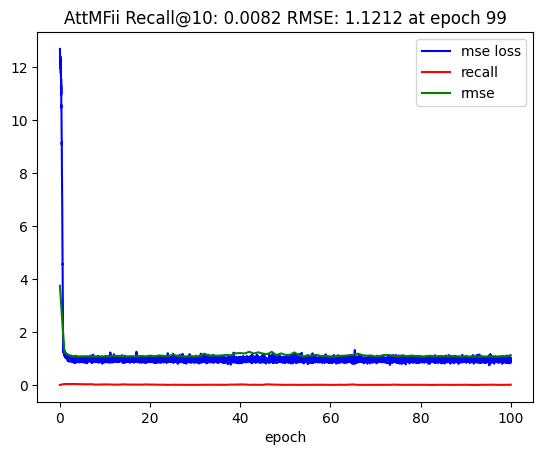

AttMFii Recall@10: 0.0082 RMSE: 1.1212 at epoch 99


In [6]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'AttMFii Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'AttMFii Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

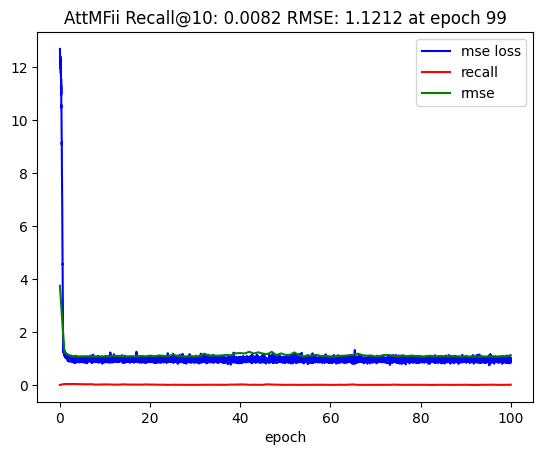

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'AttMFii Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [8]:
recall_list

[0.0,
 0.03442622950819672,
 0.03278688524590164,
 0.03442622950819672,
 0.03114754098360656,
 0.02622950819672131,
 0.022950819672131147,
 0.027868852459016394,
 0.009836065573770493,
 0.01639344262295082,
 0.019672131147540985,
 0.018032786885245903,
 0.011475409836065573,
 0.009836065573770493,
 0.022950819672131147,
 0.014754098360655738,
 0.011475409836065573,
 0.013114754098360656,
 0.009836065573770493,
 0.019672131147540985,
 0.013114754098360656,
 0.011475409836065573,
 0.006557377049180328,
 0.00819672131147541,
 0.001639344262295082,
 0.00819672131147541,
 0.004918032786885246,
 0.004918032786885246,
 0.001639344262295082,
 0.004918032786885246,
 0.003278688524590164,
 0.003278688524590164,
 0.006557377049180328,
 0.006557377049180328,
 0.006557377049180328,
 0.004918032786885246,
 0.006557377049180328,
 0.004918032786885246,
 0.013114754098360656,
 0.011475409836065573,
 0.018032786885245903,
 0.01639344262295082,
 0.003278688524590164,
 0.00819672131147541,
 0.004918032786

In [9]:
rmse_list

[3.7455972893458633,
 1.2306367789693327,
 1.1245203585174774,
 1.0837155120360356,
 1.078866068142189,
 1.0794741164369115,
 1.0798835786129213,
 1.0806968530933305,
 1.0752908246738966,
 1.075033260540629,
 1.0757657650433567,
 1.074550896360011,
 1.0957805313810773,
 1.0959040003764366,
 1.0817933630154524,
 1.0771794249849185,
 1.084844519466417,
 1.0813783404085155,
 1.094917818321201,
 1.0794666069841494,
 1.106377056605641,
 1.0767018973980662,
 1.1138457891371025,
 1.0954855092499227,
 1.0760895685474994,
 1.1447768745241902,
 1.0992966202060626,
 1.0800374525251968,
 1.0771902150606003,
 1.085391778837538,
 1.0766088356709975,
 1.0845085457570205,
 1.1824871467391809,
 1.1122839492860699,
 1.1083639131118217,
 1.104044451637574,
 1.1154494737871736,
 1.1335232313793397,
 1.1162757087130644,
 1.1958056660463214,
 1.2019899141361368,
 1.1877926917508208,
 1.2498620433973222,
 1.1858843805330728,
 1.2303489021185063,
 1.1836231593138755,
 1.1620754204926667,
 1.2503703999097708,


In [10]:
# max(recall_list), min(rmse_list) 
print(f'AttMFii Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'AttMFii Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

AttMFii Max Recall@10: 0.0344 at epoch 1
AttMFii Min RMSE: 1.0712 at epoch 93
